In [ ]:
import pandas as pd
from pydatagen.functions import textify
from fastai.vision.all import *

raw = pd.read_csv("../datagen/small_phone_number_sample.csv")
raw.head()

,locale,name,language,phone,license,address,city,country
0,ar_AA,عاتب بنو ذي أصبح,Arabic,426.834.4237x982,KXB 472,02252 ميرفاب Pine Apt. 788,West رجاء,Nicaragua
1,ar_AA,أسيل البديري,Oromo,756402-1633,N84-GAF,438 يعرب Cape Suite 066,New سامح,Netherlands Antilles
2,ar_AA,الأستاذة اعتكاف المرازيق,Rundi,577.587.9447,4UZ 505,1437 جرّاح Viaduct,البخاريburgh,Belarus
3,ar_AA,ناجي العسلي,Occitan,001-271-801-4295x8432,1L 47192,352 مقدام Path Suite 951,حميضةmouth,Pitcairn Islands
4,ar_AA,بثينة العقيدات,Tajik,806.851.4642,ZEQ 491,8775 ساجد Forge,بنو هلالbury,Colombia


Lots of data here.  The phone column contains positive examples, the rest essentially are negative examples.  However, we essentially need to turn each individual column into a set of key,value pairs (and label each row appropriately) before we can feed the data to a classifier.

First we'll create a label column, initialized with all 0's.

In [ ]:
raw['is_phone'] = 0

Now use the 'melt' function to make each column a different key, and let the 'is_phone' column be the value.

In [ ]:
# melted = raw.melt(id_vars=['is_phone'], value_vars=['locale','name','language','phone','license','address','city','country'])
melted = raw.melt(id_vars=['is_phone'], value_vars=['locale','name','language','phone','license','address','city','country'])
melted.head()


,is_phone,variable,value
0,0,locale,ar_AA
1,0,locale,ar_AA
2,0,locale,ar_AA
3,0,locale,ar_AA
4,0,locale,ar_AA


Obviously a lot of duplicates for locale here (which is more of a categorical variable), so we might as well remove those.

In [ ]:
melted = melted.drop_duplicates()
melted.head()

,is_phone,variable,value
0,0,locale,ar_AA
10,0,locale,ar_EG
20,0,locale,ar_JO
30,0,locale,ar_PS
40,0,locale,ar_SA


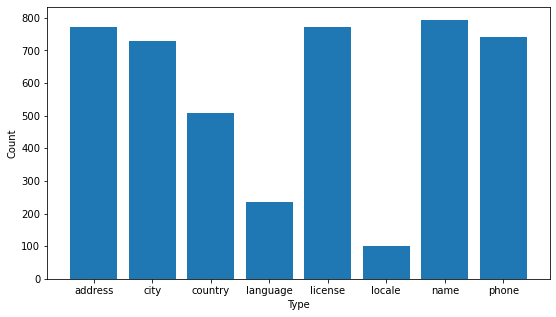

In [ ]:
group_counts = melted.groupby(['variable']).size()

x_pos = [i for i, _ in enumerate(group_counts)]

plt.figure(figsize=(9, 5))
plt.bar(x_pos, group_counts.values)
plt.ylabel("Count")
plt.xlabel("Type")
plt.xticks(x_pos, group_counts.index)

plt.show()

We have roughly the same number of records for phone (positive examples), as we do for name, license, and address (negative examples).  We'll
create a 50-50 mix of positive to negative examples and draw a stratified sample for the negatives from each of name, license, and address.

In [ ]:
# set 'is_phone' column on the phone values
melted.loc[melted['variable'] == 'phone', 'is_phone'] = 1

positives = melted.loc[melted['is_phone'] == 1]
positives

,is_phone,variable,value
2379,1,phone,426.834.4237x982
2380,1,phone,756402-1633
2381,1,phone,577.587.9447
2382,1,phone,001-271-801-4295x8432
2383,1,phone,806.851.4642
...,...,...,...
3167,1,phone,04 7138886
3168,1,phone,04-29114497
3169,1,phone,07 3644767
3170,1,phone,07 6969158


Now create the negative examples of roughly the same size.

In [ ]:
negatives = melted.loc[melted.variable.isin(['name', 'address', 'license'])].sample(frac=0.33, replace=False, random_state=42)
negatives

,is_phone,variable,value
1348,0,name,Rute Skuja
3748,0,license,66A 2654
3731,0,license,SKG 808
1444,0,name,Sérgio Morais
3927,0,license,WAC-577
...,...,...,...
4652,0,address,Maistrova ulica 0a
1124,0,name,Andres Liivak
4263,0,address,647 José María Unions
987,0,name,Mrs. Jodie Roberts


Let's check our negatives count just to be sure.

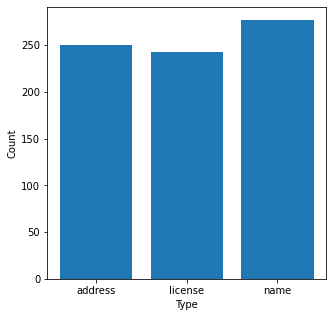

In [ ]:
neg_counts = negatives.groupby(['variable']).size()

x_pos = [i for i, _ in enumerate(neg_counts)]

plt.figure(figsize=(5, 5))
plt.bar(x_pos, neg_counts.values)
plt.ylabel("Count")
plt.xlabel("Type")
plt.xticks(x_pos, neg_counts.index)

plt.show()

In [ ]:
len(positives), len(negatives)

(742, 770)

In [ ]:
full_data_df = pd.concat([positives, negatives])
textified_df = pd.DataFrame({'textified': full_data_df['value'].astype(str).apply(lambda x: textify(x, length=30))})
textified_df

,textified
2379,"[52, 50, 54, 46, 56, 51, 52, 46, 52, 50, 51, 55, 120, 57, 56, 50, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2380,"[55, 53, 54, 52, 48, 50, 45, 49, 54, 51, 51, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2381,"[53, 55, 55, 46, 53, 56, 55, 46, 57, 52, 52, 55, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2382,"[48, 48, 49, 45, 50, 55, 49, 45, 56, 48, 49, 45, 52, 50, 57, 53, 120, 56, 52, 51, 50, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2383,"[56, 48, 54, 46, 56, 53, 49, 46, 52, 54, 52, 50, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...
4652,"[77, 97, 105, 115, 116, 114, 111, 118, 97, 32, 117, 108, 105, 99, 97, 32, 48, 97, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1124,"[65, 110, 100, 114, 101, 115, 32, 76, 105, 105, 118, 97, 107, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4263,"[54, 52, 55, 32, 74, 111, 115, 1, 32, 77, 97, 114, 1, 97, 32, 85, 110, 105, 111, 110, 115, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
987,"[77, 114, 115, 46, 32, 74, 111, 100, 105, 101, 32, 82, 111, 98, 101, 114, 116, 115, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [ ]:
pd.DataFrame(textified_df['textified'].to_list())
# .loc[:,:29].values


,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,52,50,54,46,56,51,52,46,52,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55,53,54,52,48,50,45,49,54,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,55,55,46,53,56,55,46,57,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48,48,49,45,50,55,49,45,56,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56,48,54,46,56,53,49,46,52,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,77,97,105,115,116,114,111,118,97,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,65,110,100,114,101,115,32,76,105,105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,54,52,55,32,74,111,115,1,32,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1510,77,114,115,46,32,74,111,100,105,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Not sure why but our 30 element textified list is somehow being split into 69 columns.  Need to select out only the columns we want.

In [ ]:
feature_df = pd.DataFrame(textified_df['textified'].to_list()).loc[:,:29]
feature_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,52,50,54,46,56,51,52,46,52,50,...,1,1,1,1,1,1,1,1,1,1
1,55,53,54,52,48,50,45,49,54,51,...,1,1,1,1,1,1,1,1,1,1
2,53,55,55,46,53,56,55,46,57,52,...,1,1,1,1,1,1,1,1,1,1
3,48,48,49,45,50,55,49,45,56,48,...,50,1,1,1,1,1,1,1,1,1
4,56,48,54,46,56,53,49,46,52,54,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,77,97,105,115,116,114,111,118,97,32,...,1,1,1,1,1,1,1,1,1,1
1508,65,110,100,114,101,115,32,76,105,105,...,1,1,1,1,1,1,1,1,1,1
1509,54,52,55,32,74,111,115,1,32,77,...,115,1,1,1,1,1,1,1,1,1
1510,77,114,115,46,32,74,111,100,105,101,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
label_df = full_data_df['is_phone']
label_df

2379    1
2380    1
2381    1
2382    1
2383    1
       ..
4652    0
1124    0
4263    0
987     0
4618    0
Name: is_phone, Length: 1512, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# train_x_df = feature_df.sample(frac=0.9, replace=False, random_state=42)

train_x_df, valid_x_df, train_y_df, valid_y_df = train_test_split(feature_df, label_df, test_size=0.10, random_state=42)
train_x_df.shape, valid_x_df.shape, train_y_df.shape, valid_y_df.shape

((1360, 30), (152, 30), (1360,), (152,))

In [ ]:
train_x_tens = torch.tensor(train_x_df.values)
train_y_tens = torch.tensor(train_y_df.values).unsqueeze(1)
valid_x_tens = torch.tensor(valid_x_df.values)
valid_y_tens = torch.tensor(valid_y_df.values).unsqueeze(1)

train_x_tens.shape, train_y_tens.shape, valid_x_tens.shape, valid_y_tens.shape

(torch.Size([1360, 30]),
 torch.Size([1360, 1]),
 torch.Size([152, 30]),
 torch.Size([152, 1]))

In [ ]:
trainset = list(zip(train_x_tens.float(), train_y_tens))
validset = list(zip(valid_x_tens.float(), valid_y_tens))

In [ ]:
# batch_size of about 100 seems best so far
traindl = DataLoader(trainset, batch_size=256)
# xb,yb = first(traindl)
# print("Training example: {}, {}".format(xb,yb))

# validdl = DataLoader(validset, batch_size=30)
validdl = DataLoader(validset, batch_size=256)
# xt, yt = first(validdl)
# print("Validation example: {}, {}".format(xt.shape, yt.shape))

In [ ]:
def phone_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1-predictions, predictions).mean()

def phone_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [ ]:
dls = DataLoaders(traindl, validdl)

simple_net = nn.Sequential(
    nn.Linear(30, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=phone_loss, metrics=phone_accuracy)

In [ ]:
learn.fit(80, 0.1)

epoch,train_loss,valid_loss,phone_accuracy,time
0,0.444057,0.441128,0.532895,00:00
1,0.395814,0.433069,0.598684,00:00
2,0.356641,0.268581,0.743421,00:00
3,0.326156,0.263872,0.750000,00:00
4,0.304778,0.292268,0.736842,00:00
5,0.292031,0.279281,0.743421,00:00
6,0.280439,0.268902,0.763158,00:00
7,0.269834,0.392346,0.638158,00:00
8,0.265625,0.189706,0.815789,00:00
9,0.256665,0.266426,0.769737,00:00


In [ ]:
learn.export()

AttributeError: 'list' object has no attribute 'new_empty'

In [ ]:
import fastai
print(fastai.__version__)

2.2.7


In [ ]:
# try with resnet
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=phone_accuracy)
learn.fit_one_cycle(1, 0.1)


AssertionError: `n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`